## 女性比率予測のモデル構築

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 94, 94, 64)        1792      
                                                                 
 batch_normalization_39 (Ba  (None, 94, 94, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 47, 47, 64)        0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 45, 45, 128)       73856     
                                                                 
 batch_normalization_40 (Ba  (None, 45, 45, 128)       512       
 tchNormalization)                                               
                                                     

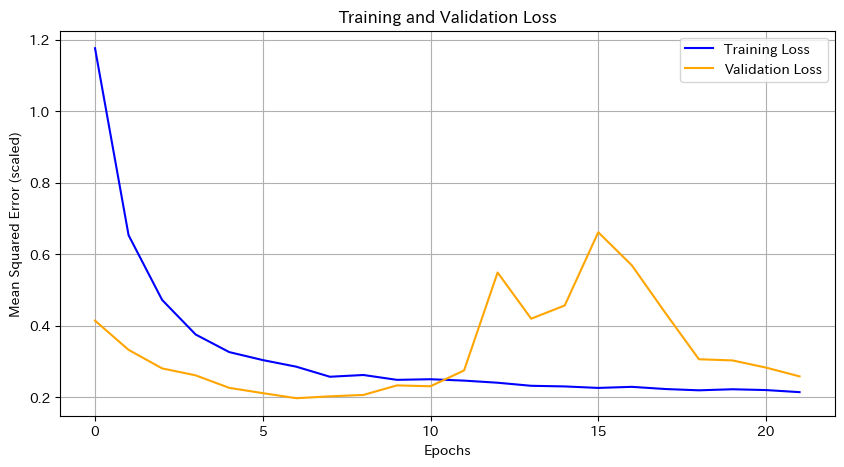

7/7 [==============================] - 0s 24ms/step
Mean Absolute Error: 0.14229648767590525


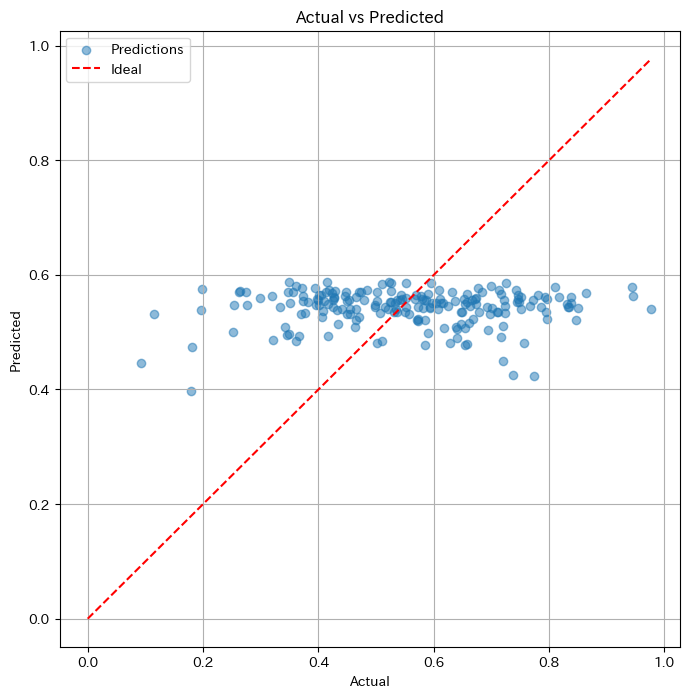

Actual: 0.83, Predicted: 0.54
Actual: 0.27, Predicted: 0.57
Actual: 0.66, Predicted: 0.55
Actual: 0.51, Predicted: 0.54
Actual: 0.65, Predicted: 0.51


/home/teacher/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from PIL import Image, ImageEnhance
import os
import sqlite3
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------------------------------------------------
# 1. データの読み込みと前処理
# --------------------------------------------------

# データセットのパス
dataset_path = './SM_pan.db'  # SQLiteデータベースファイルのパス
folder_path = './resized_picture/joseiHiritsu/'  # 画像フォルダのパス

# SQLiteデータベースの読み込み
conn = sqlite3.connect(dataset_path)  # SQLiteデータベースに接続
df = pd.read_sql_query("SELECT * FROM joseiHiritsu", conn)  # テーブル名を指定
conn.close()

# ターゲット変数の定義
y = []
X = []

# 画像データの読み込みと前処理
for index, row in df.iterrows():
    img_path = os.path.join(folder_path, f"{row['No']}.jpg")
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB')
        img = img.resize((96, 96))
        
        # コントラストの調整
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(1.5)  # コントラストを1.5倍に調整
        
        img = np.array(img, dtype=np.float32) / 255.0  # 正規化
        X.append(img)
        y.append(row['女性個数比率'])

X = np.array(X)
y = np.array(y).reshape(-1, 1)

# ターゲット変数のスケーリング（MinMaxScalerを使用）
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)  # yを0~1にスケーリング

# --------------------------------------------------
# 2. 訓練データとテストデータの分割
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_scaled, test_size=0.2, random_state=42
)

# --------------------------------------------------
# 3. モデル定義
#    - Batch Normalization / Dropout の導入例
# --------------------------------------------------
def create_model(input_shape, output_units):
    model = models.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', name='conv2'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', name='conv3'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))

    # 出力層（回帰なので活性化なし）
    model.add(layers.Dense(output_units))

    return model

# 入力形状と出力ユニット数
input_shape = (96, 96, 3)
output_units = 1  # 予測する数値（女性個数比率）のみ

# モデルの作成
model = create_model(input_shape, output_units)

# --------------------------------------------------
# 4. モデルのコンパイル・学習
#    - EarlyStopping / ReduceLROnPlateau の導入例
# --------------------------------------------------
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='mse'
)

model.summary()

# コールバックの設定
early_stopping = EarlyStopping(
    monitor='val_loss',  # 監視対象をval_lossに設定
    patience=15,         # 15エポック連続で改善がなければ打ち切り
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,    # 学習率を1/10にする
    patience=10,    # 5エポック連続で改善がなければ学習率を下げる
    min_lr=1e-7    # 学習率の下限
)

# データ拡張
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

datagen.fit(X_train)

# トレーニングの実行
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# --------------------------------------------------
# 5. モデルの評価と結果の可視化
# --------------------------------------------------

# テストデータでの評価（MSE）
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE, scaled): {test_loss}")

# 学習曲線の可視化
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (scaled)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 予測
y_pred_scaled = model.predict(X_test)
# スケールを元に戻す
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)
# MAEなど他の指標も計算
mae = mean_absolute_error(y_test_original, y_pred)
print(f"Mean Absolute Error: {mae}")

# 散布図による可視化
plt.figure(figsize=(8, 8))

# データをフラット化
y_test_flat = y_test_original.flatten()
y_pred_flat = y_pred.flatten()

plt.scatter(y_test_flat, y_pred_flat, alpha=0.5, label='Predictions')
plt.plot([0, max(y_test_flat)], [0, max(y_test_flat)], color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

# 予測値と実際の値の比較（最初の5サンプル）
for i in range(5):
    actual = y_test_original[i][0]
    pred = y_pred[i][0]
    print(f"Actual: {actual:.2f}, Predicted: {pred:.2f}")


# モデルの保存
model.save('hiritsu_model.h5')
